<a href="https://colab.research.google.com/github/Ksenyff/ICV-2024/blob/main/Spiridonova_Homography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

## Описание

Дано изображение документа, сделанное под углом (с перспективныи искажением).

Ваша задача состоит в следующем:
1. Вручную отметить 4 угла документа (координаты в пикселях).
2. Вычислить матрицу гомографии для преобразования выбранных точек в прямоугольник (например, если было сделано фото листа А4, то прямоугольник размером 297 на 210 мм).
3. Примените перспективное преобразование над изображением для получения "выпрямленного" изображения документа.

**Входные данные**: исходное изображение документа (или любого другого плоского объекта с выраженными углами - минимум 4 угла).

**Выходные данные**: исправленное изображение документа (будто документ расположен параллельно плоскости матрицы камеры).

## Этапы выполнения

### 1. Выбор угловых точек

- Загрузить изображение и позволить пользователю кликнуть на 4 угла документа (порядок: левый-верхний, правый-верхний, правый-нижний, левый-нижний). На первых этапах тестирования можете задать координаты углов в программе.
- Сохраните координаты как `src_corner_points`.

### 2. Определение целевых размеров

- Исправленный документ должен иметь более или менее корректные пропорции (например, соотношение сторон листа А4 = 297 / 210 = 1.414).

- Задайте координаты исправленных углов как `dst_corner_points`:
```python
dst_corner_points = np.array([
  [0, 0],          # левый-верхний угол (LT)
  [width, 0],      # правый-верхний угол (RT)
  [width, height], # правый-нижний угол (RB)
  [0, height]      # левый-нижний угол (LB)
])
```

### 3. Расчет матрицы гомографии

- Использовать `cv2.getPerspectiveTransform()` для вычисления матрицы `H`, преобразующей `src_corner_points` в `dst_corner_points`.

### 4. Применение преобразования

- Использовать `cv2.warpPerspective()` с матрицей `H` для получения исправленного изображения.

### 5. Визуализация и сохранение

- Показать исходное и исправленное изображения "бок о бок" (склеить изображения так чтобы между ними был белый разделитель толщиной 32 пикселя).
- Сохранить результат в формате `PNG` под любым названием (например, `doc-homography.PNG`). Файл должен корректно открываться.

### 6. Работа с видеопотоком камеры

- Используйте видеопоток с камеры для захвата изображения. Изображение должно захватываться по запросу пользователя - например, через ROS-сервис или стандартный поток ввода (терминал).

Условно: "ожидаем пока пользователь нажмет кнопку S и тогда берем текущий кадр с камеры".

### Опционально

1. Автоматическое опеределение углов через Canny, контуры и аппроксимацию многоугольника.

2. Вычисление исходного соотношения сторон документа по многоугольнику.

3. Использовать видеопоток с камеры для коррекции перспективного искажения "на лету". Вычисление углов и исправление осуществляется для всех кадров видеопотока по мере их "поступления".


## Пример структуры кода (без ROS)

```python
import cv2
import numpy as np

# Загрузка изображения
image = cv2.imread("document.jpg") # или получение кадра из ROS-топика

# Этап 1: Ручной выбор углов (можно через cv2.setMouseCallback())
src_corner_points = [...]  # 4 точки, введенные пользователем

# Этап 2: Целевые координаты (например, в соотношении сторон формата A4)
width, height = 210, 297
dst_corner_points = np.array([...], dtype=np.float32)

# Этап 3: Вычисление матрицы гомографии
H = cv2.getPerspectiveTransform(src_corner_points, dst_corner_points)

# Этап 4: Перспективное преобразование
corrected_img = cv2.warpPerspective(image, H, (width, height))

# Этап 5: Визуализация
cv2.imshow("Исходное", image)
cv2.imshow("Исправленное", corrected_img)
cv2.waitKey(0)
```

## Пример ручного выбора углов (мышкой)

```python
class CornerSelector:
    def __init__(self, image, window_name="Select 4 сorners"):
        self.image = image.copy()
        self.display_image = image.copy()
        self.window_name = window_name
        self.corners = []
        self.is_completed = False
        
    def select_corners(self):
        cv2.namedWindow(self.window_name)
        cv2.setMouseCallback(self.window_name, self._mouse_callback)
        
        print("Инструкция:")
        print("1. Кликните ЛКМ по 4 углам документа (по часовой стрелке или против)")
        print("2. После выбора 4 точек нажмите ESC для завершения")
        
        while True:
            cv2.imshow(self.window_name, self.display_image)
            key = cv2.waitKey(1) & 0xFF
            
            # ESC для завершения или автоматически после 4 точек
            if key == 27 or self.is_completed:
                break
        
        cv2.destroyWindow(self.window_name)
        if not self.is_completed:
          return None
        
        return np.array(self.corners, dtype=np.float32)
    
    def _mouse_callback(self, event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN and len(self.corners) < 4:
            self.corners.append((x, y))
            print(f"Выбрана точка {len(self.corners)}: ({x}, {y})")
            
            # Обновляем изображение с отметками
            self.display_image = self.image.copy()
            for i, (cx, cy) in enumerate(self.corners, 1):
                cv2.circle(self.display_image, (cx, cy), 10, (0, 0, 255), -1)
                cv2.putText(self.display_image, str(i), (cx + 15, cy - 15),
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            if len(self.corners) == 4:
                self.is_completed = True
                print("Все 4 точки выбраны!")


# Пример использования
if __name__ == "__main__":
    # Загрузка изображения
    image = ...
    
    # Создаем селектор и запускаем процесс выбора углов
    selector = CornerSelector(image)
    selected_corners = selector.select_corners()
    
    if selected_corners is not None:
        print("\nВыбранные точки:")
        print(selected_corners)
        
        # Здесь можно продолжить с вычислением гомографии...
    else:
        print("Не удалось выбрать 4 точки!")
```

## Вопросы для обсуждения

1. Почему достаточно 4 точке для вычисления гомографии? Почему недостаточно 3 точек?
2. Как повлияет на результат неточное выделение углов документа?

 **Ответы на вопрос:**

1.a)  т.к матрица гомографии представляет собой матрицу 3х3. С учетом масштабируеммости можно сказать ,что матрица имеет 8 степеней свободы. Одна пара точек даёт 2 уравнения. Значит, для решения уравнения необходимо 4 точки, чтобы система стала полной и можно было однозначно восстановить матрицу гомографии.

1.b) При использовании 3х точек , мы получем решение для 6ти уравнений, т.е недоопределенную  систему. Использвание 3х точек хорошо подойдёт для задач: gоворотов,масштабирований,сдвигов, но не для перспективных искажений.

2.Последствия:
Искажение формы документа,cмещение содержимого,yарушение пропорций,потеря информации,возникновение артефакты



# New

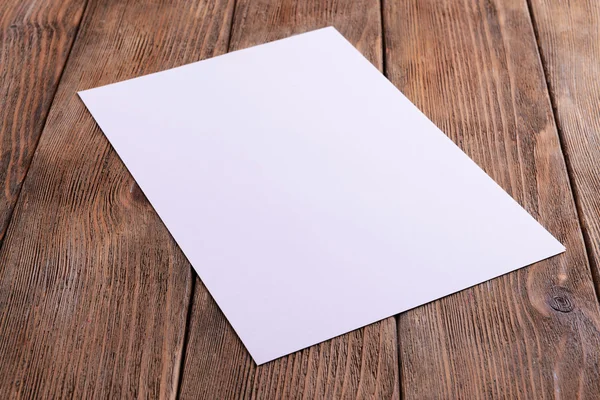

In [3]:
import cv2
import requests
import numpy as np
from google.colab.patches import cv2_imshow

# URL изображения
image_url = "https://st2.depositphotos.com/1177973/6137/i/450/depositphotos_61370509-stock-photo-paper-sheet-on-table-close.jpg "

try:
    response = requests.get(image_url)
    if response.status_code != 200:
        raise Exception(f"Не удалось загрузить изображение. Статус: {response.status_code}")

    image_data = np.frombuffer(response.content, dtype=np.uint8)
    image = cv2.imdecode(image_data, cv2.IMREAD_COLOR)

    if image is None:
        raise Exception("Не удалось декодировать изображение.")

    cv2_imshow(image)

except Exception as e:
    print(f"Ошибка: {e}")

Целевые размеры: 329x327
Изображение сохранено как 'list.png'


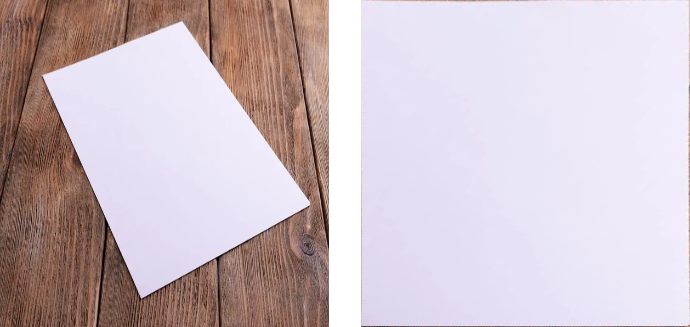

In [18]:
src_corner_points = np.array([
    [78, 92],
    [332, 26],
    [567, 250],
    [258, 365],

], dtype=np.float32)

def distance(p1, p2):
    return np.sqrt(((p1[0]-p2[0])**2) + ((p1[1]-p2[1])**2))

width_top = distance(src_corner_points[0], src_corner_points[1])
width_bottom = distance(src_corner_points[3], src_corner_points[2])
width = int(max(width_top, width_bottom))

height_left = distance(src_corner_points[0], src_corner_points[3])
height_right = distance(src_corner_points[1], src_corner_points[2])
height = int(max(height_left, height_right))

print(f"Целевые размеры: {width}x{height}")

dst_corner_points = np.array([
    [0, 0],
    [width - 1, 0],
    [width - 1, height - 1],
    [0, height - 1]
], dtype=np.float32)

H = cv2.getPerspectiveTransform(src_corner_points, dst_corner_points)
corrected_image = cv2.warpPerspective(image, H, (width, height))

separator = 32
original_resized = cv2.resize(image, (corrected_image.shape[1], corrected_image.shape[0]))
white_line = 255 * np.ones((corrected_image.shape[0], separator, 3), dtype=np.uint8)
combined = np.hstack((original_resized, white_line, corrected_image))


from google.colab.patches import cv2_imshow
cv2.imwrite("list.png", corrected_image)
print("Изображение сохранено как 'list.png'")
cv2_imshow(combined)


# Работа с видеопотоком камеры

In [19]:
import cv2
import numpy as np

# Функция для автоматического определения углов документа
def detect_document_corners(image):
    # Преобразование в grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Улучшение контрастности
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Каннифицируем изображение
    edges = cv2.Canny(gray, 50, 200)

    # Находим контуры
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Сортируем контуры по площади (по убыванию)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    if len(contours) == 0:
        return None

    # Берём самый большой контур
    largest_contour = contours[0]

    # Аппроксимируем многоугольник
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)

    # Если аппроксимированный многоугольник имеет 4 вершины — это наш документ
    if len(approx) == 4:
        corners = approx.reshape(4, 2).astype(np.float32)
        return corners

    return None

# Главная функция
def main():
    # Захват видеопотока с камеры
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Ошибка: не удалось открыть камеру.")
        return

    while True:
        # Читаем кадр с камеры
        ret, frame = cap.read()

        if not ret:
            print("Ошибка: не удалось получить кадр.")
            break

        # Отображаем текущий кадр
        cv2.imshow("Camera Feed", frame)

        # Ожидаем нажатие клавиши 's' для захвата кадра
        key = cv2.waitKey(1) & 0xFF
        if key == ord('s'):
            print("Кадр захвачен!")

            # Автоматическое определение углов документа
            corners = detect_document_corners(frame)
            if corners is None:
                print("Не удалось найти углы документа.")
                continue

            # Рассчитываем целевые размеры
            width_top = int(np.linalg.norm(corners[0] - corners[1]))
            width_bottom = int(np.linalg.norm(corners[3] - corners[2]))
            width = max(width_top, width_bottom)

            height_left = int(np.linalg.norm(corners[0] - corners[3]))
            height_right = int(np.linalg.norm(corners[1] - corners[2]))
            height = max(height_left, height_right)

            # Целевые точки (углы выпрямленного документа)
            dst_corners = np.array([
                [0, 0],
                [width - 1, 0],
                [width - 1, height - 1],
                [0, height - 1]
            ], dtype=np.float32)

            # Вычисляем матрицу гомографии
            H = cv2.getPerspectiveTransform(corners, dst_corners)

            # Применяем перспективное преобразование
            corrected_image = cv2.warpPerspective(frame, H, (width, height))

            # Отображаем оригинальное и исправленное изображения
            combined = np.hstack((frame, corrected_image))
            cv2.imshow("Original vs Corrected", combined)

        # Выход при нажатии клавиши 'q'
        if key == ord('q'):
            break

    # Освобождаем ресурсы
    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

Ошибка: не удалось открыть камеру.
